Objectives:

Workload for PLP: Dennis:
For individual creators:
1) For each video x 15 playlist, +ve or -ve (overall sentiment) using Comments
2) For each topic in each video, +ve or -ve (which topic receive positive sentiments) using Topics from XJ
How? Vader
3a) Extract the Entity, and find out the sentiments for each Entity. 
How? 
(Semi-supervised) PU Learning 


Ley Ling:
3b) Extract the Aspects, and find out the sentiments for each Aspect. 
How? 
Freq
Lexicon based
DNN (BART)

For Business:
4) Do a comparison of S/N 1 and 2
5) For each topic/Entity/Aspect, find out which content creator has the most +ve sentiment
6) Time series - plot of their sentiments over time. Choose the most popular content creator by virtue of most positive comments received and also number of comments received.

<b> Understanding JSON

In [1]:
import json
from collections import defaultdict
import pandas as pd

# Load the JSON file
file_path = "data.json"  # Update this path if needed
with open(file_path, "r") as f:
    data = json.load(f)

# Initialize a structure to hold the summary
summary = defaultdict(lambda: {"playlist_count": 0, "playlists": {}})

# Walk through the JSON structure
for creator, playlists in data.items():
    summary[creator]["playlist_count"] = len(playlists)
    for playlist_id, videos in playlists.items():
        summary[creator]["playlists"][playlist_id] = {
            "video_count": len(videos),
            "videos": {}
        }
        for video_id, video_data in videos.items():
            comment_count = len(video_data.get("comments", []))
            topic_count = len(video_data.get("topic", []))  # ← Count topics here
            summary[creator]["playlists"][playlist_id]["videos"][video_id] = {
                "comment_count": comment_count,
                "topic_count": topic_count
            }

# Flatten the summary into a dataframe for easier viewing
rows = []
for creator, creator_data in summary.items():
    for playlist_id, playlist_data in creator_data["playlists"].items():
        for video_id, video_data in playlist_data["videos"].items():
            rows.append({
                "Content Creator": creator,
                "Playlist ID": playlist_id,
                "Video ID": video_id,
                "Number of Comments": video_data["comment_count"],
                "Number of Topics": video_data["topic_count"]
            })

# Create DataFrame
df = pd.DataFrame(rows)

# Display the DataFrame
print(df)

# Save to CSV
df.to_csv("video_comment_summary.csv", index=False)

        Content Creator                         Playlist ID     Video ID  \
0    Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  ZLKh8w3SGr0   
1    Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  7LMgmg0I0GA   
2    Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  fpjcbTGaYgs   
3    Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  oeh_bURqRPs   
4    Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  yrpq8YFvZWs   
..                  ...                                 ...          ...   
208      E for Electric  PLXAbfWOvf5YtNes11pbNdgq3N5dbZg0Qy  8VfkOSbzN1c   
209      E for Electric  PLXAbfWOvf5YtNes11pbNdgq3N5dbZg0Qy  YeWq47CTDmE   
210      E for Electric  PLXAbfWOvf5YtNes11pbNdgq3N5dbZg0Qy  vp5qJlr4go0   
211      E for Electric  PLXAbfWOvf5YtNes11pbNdgq3N5dbZg0Qy  RyeCae8s7Lk   
212      E for Electric  PLXAbfWOvf5YtNes11pbNdgq3N5dbZg0Qy  xxpLykrmDA4   

     Number of Comments  Number of Topics  
0                   390                15  

In [2]:
# Neatly format with gradient background and center alignment
df.style\
    .background_gradient(subset=["Number of Comments", "Number of Topics"], cmap="Blues")\
    .format(na_rep="N/A")\
    .set_properties(**{"text-align": "left"})

In [3]:
creator_summary = df.groupby("Content Creator").agg({
    "Video ID": "count",
    "Number of Comments": "sum",
    "Number of Topics": "sum"
}).rename(columns={
    "Video ID": "Total Videos",
    "Number of Comments": "Total Comments",
    "Number of Topics": "Total Topics"
}).reset_index()

# View summary
print(creator_summary)

        Content Creator  Total Videos  Total Comments  Total Topics
0          Bjorn Nyland            26            1354           136
1        E for Electric            28            6709           293
2  Electric Vehicle Man            64            5688           290
3    Fully Charged Show            37           19740           223
4          Now You Know            58           18239           267


Scan through each comment, determine if it is positive or negative and then return an overall sentiment for the video based on all the comments for that video. Repeat for each of the video.

In [4]:
import json
import pandas as pd
from textblob import TextBlob
import plotly.graph_objects as go

# Load JSON data
json_file_path = "data.json"  # Update this if needed
with open(json_file_path, "r") as f:
    data = json.load(f)

# Function to classify sentiment
def get_sentiment_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

# Analyze each video
video_sentiment_summary = []

for creator, playlists in data.items():
    for playlist_id, videos in playlists.items():
        for video_id, video_data in videos.items():
            comments = video_data.get("comments", [])
            sentiments = [get_sentiment_label(c["Comment"]) for c in comments]

            sentiment_counts = {
                "Positive": sentiments.count("Positive"),
                "Negative": sentiments.count("Negative"),
                "Neutral": sentiments.count("Neutral")
            }

            total = len(sentiments) if sentiments else 1  # prevent division by zero

            # Determine majority sentiment
            if not sentiments:
                overall_sentiment = "No Comments"
            elif sentiment_counts["Positive"] > sentiment_counts["Negative"]:
                overall_sentiment = "Positive"
            elif sentiment_counts["Negative"] > sentiment_counts["Positive"]:
                overall_sentiment = "Negative"
            else:
                overall_sentiment = "Neutral"

            # Collect topics if available
            topics = video_data.get("topic", [])
            topic_count = len(topics)

            # Append results
            video_sentiment_summary.append({
                "Content Creator": creator,
                "Playlist ID": playlist_id,
                "Video ID": video_id,
                "Positive Comments": sentiment_counts["Positive"],
                "Negative Comments": sentiment_counts["Negative"],
                "Neutral Comments": sentiment_counts["Neutral"],
                "Positive %": round(sentiment_counts["Positive"] / total * 100, 1),
                "Negative %": round(sentiment_counts["Negative"] / total * 100, 1),
                "Neutral %": round(sentiment_counts["Neutral"] / total * 100, 1),
                "Overall Sentiment": overall_sentiment,
                "Number of Topics": topic_count,
                "Topics": ", ".join(topics)
            })

# Convert to DataFrame
df_sentiment = pd.DataFrame(video_sentiment_summary)

# Print or export
print(df_sentiment.head())
df_sentiment.to_csv("video_sentiment_summary.csv", index=False)

# Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(df_sentiment.columns),
        fill_color='paleturquoise',
        align='left'
    ),
    cells=dict(
        values=[df_sentiment[col] for col in df_sentiment.columns],
        fill_color='lavender',
        align='left'
    )
)])

fig.show()

      Content Creator                         Playlist ID     Video ID  \
0  Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  ZLKh8w3SGr0   
1  Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  7LMgmg0I0GA   
2  Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  fpjcbTGaYgs   
3  Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  oeh_bURqRPs   
4  Fully Charged Show  PLzD0K2OhbVfHtiJwiepCu_qwONFRaS06p  yrpq8YFvZWs   

   Positive Comments  Negative Comments  Neutral Comments  Positive %  \
0                166                 52               172        42.6   
1                273                 58               217        49.8   
2                683                193               587        46.7   
3                253                 47               212        49.4   
4                494                155               502        42.9   

   Negative %  Neutral % Overall Sentiment  Number of Topics  \
0        13.3       44.1          Positive          

In [5]:
# Style the table with color gradients for key metrics
df_sentiment.style\
    .background_gradient(subset=["Positive %", "Negative %", "Neutral %"], cmap="Blues")\
    .format(na_rep="N/A")\
    .set_properties(**{'text-align': 'left'})

In [8]:
from tabulate import tabulate

print(tabulate(df_sentiment.head(220), headers='keys', tablefmt='fancy_grid', showindex=False))

╒══════════════════════╤════════════════════════════════════╤═════════════╤═════════════════════╤═════════════════════╤════════════════════╤══════════════╤══════════════╤═════════════╤═════════════════════╤════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Content Creator      │ Playlist ID                        │ Video ID    │   Positive Comments │   Negative Comments │   Neutral Comments │   Positive % │   Negative % │   Neutral % │ Overall Sentiment   │   Number of Topics │ Topics                                                                                                                                                                                                                                                       

In [9]:
columns_to_show = [
    "Content Creator", "Playlist ID", "Video ID", 
    "Overall Sentiment", "Positive %", "Negative %", "Neutral %", 
    "Number of Topics"
]

df_summary_view = df_sentiment[columns_to_show]

# Display it cleanly
df_summary_view.style.background_gradient(subset=["Positive %", "Negative %", "Neutral %"])

In [16]:
import pandas as pd
import plotly.graph_objects as go

# Load the sentiment summary CSV
file_path = "video_sentiment_summary.csv"
df = pd.read_csv(file_path)

# Group by content creator: sum sentiment columns and count videos
summary = df.groupby("Content Creator").agg({
    "Positive Comments": "sum",
    "Negative Comments": "sum",
    "Neutral Comments": "sum",
    "Number of Topics": "sum",
    "Video ID": "count"  # Total number of videos
}).rename(columns={
    "Video ID": "Total Videos",
    "Number of Topics": "Total Topics"
}).reset_index()

# Compute total comments
summary["Total Comments"] = (
    summary["Positive Comments"] +
    summary["Negative Comments"] +
    summary["Neutral Comments"]
)

# Compute average topics per video
summary["Avg Topics/Video"] = (summary["Total Topics"] / summary["Total Videos"]).round(2)

# Calculate sentiment percentages
summary["% Positive"] = (summary["Positive Comments"] / summary["Total Comments"] * 100).round(2)
summary["% Negative"] = (summary["Negative Comments"] / summary["Total Comments"] * 100).round(2)
summary["% Neutral"]  = (summary["Neutral Comments"] / summary["Total Comments"] * 100).round(2)

# Reorder columns
summary = summary[[
    "Content Creator", "Total Videos", "Total Topics", "Avg Topics/Video",
    "Positive Comments", "Negative Comments", "Neutral Comments",
    "Total Comments", "% Positive", "% Negative", "% Neutral"
]]

# Create Plotly interactive table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(summary.columns),
        fill_color='paleturquoise',
        align='left'
    ),
    cells=dict(
        values=[summary[col] for col in summary.columns],
        fill_color='lavender',
        align='left'
    )
)])

# Show the interactive table
fig.show()

/var/folders/cq/40p3kkc160d2f_8vdynrrvjw0000gn/T/ipykernel_4180/3043255018.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




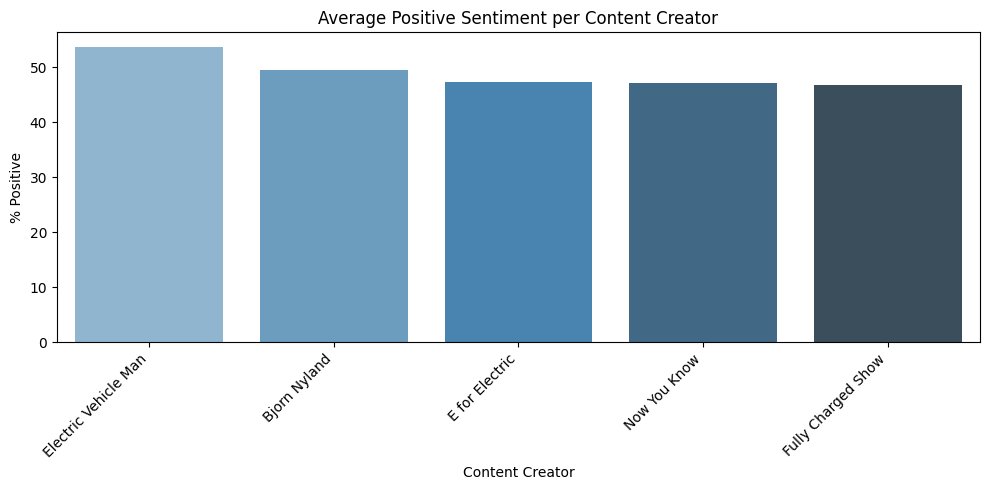

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=summary.sort_values("% Positive", ascending=False),
            x="Content Creator", y="% Positive", palette="Blues_d")
plt.title("Average Positive Sentiment per Content Creator")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [19]:
# Define percent columns
percent_cols = ["% Positive", "% Negative", "% Neutral"]

# Display styled table
summary.style\
    .background_gradient(subset=percent_cols, cmap="Blues")\
    .format({col: "{:.2f}" for col in percent_cols})\
    .set_properties(**{'text-align': 'left'})

In [ ]:
import plotly.express as px

# Use the grouped summary DataFrame from earlier
fig = px.bar(
    summary,
    x="Content Creator",
    y=["Positive Comments", "Negative Comments", "Neutral Comments"],
    title="Sentiment Breakdown per Content Creator",
    labels={"value": "Number of Comments", "variable": "Sentiment"},
    barmode="stack",
    color_discrete_sequence=["#2ca02c", "#d62728", "#1f77b4"]  # Optional: custom colors
)

fig.update_layout(
    xaxis_title="Content Creator",
    yaxis_title="Number of Comments",
    legend_title="Sentiment",
    bargap=0.15
)

fig.show()

In [23]:
# Melt the summary DataFrame to long format for sentiment percentages
melted = summary.melt(
    id_vars="Content Creator",
    value_vars=["% Positive", "% Negative", "% Neutral"],
    var_name="Sentiment",
    value_name="Percentage"
)

import plotly.express as px

# Create grouped bar chart
fig = px.bar(
    melted,
    x="Content Creator",
    y="Percentage",
    color="Sentiment",
    barmode="group",
    title="Sentiment Percentage Comparison per Creator",
    labels={"Percentage": "Sentiment (%)"}
)

# Enhance layout
fig.update_layout(
    yaxis=dict(range=[0, 100]),
    xaxis_title="Content Creator",
    yaxis_title="Percentage",
    legend_title="Sentiment Type",
    bargap=0.2
)

fig.show()

In [24]:
import plotly.express as px

fig = px.bar(
    summary.sort_values("Total Videos", ascending=True),
    x="Total Videos",
    y="Content Creator",
    orientation="h",
    title="Total Number of Videos per Creator",
    text="Total Videos",  # Show count on bars
    labels={"Total Videos": "Number of Videos"}
)

# Optional layout polish
fig.update_layout(
    xaxis_title="Number of Videos",
    yaxis_title="Content Creator",
    bargap=0.3
)

fig.update_traces(textposition='outside')

fig.show()

In [25]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# List of content creators
creators = summary["Content Creator"].tolist()

# Ensure only up to 5 creators (or modify layout dynamically if needed)
n_creators = len(creators)
cols = n_creators if n_creators <= 5 else 5

# Create subplot grid: 1 row, N columns
fig = make_subplots(
    rows=1,
    cols=cols,
    specs=[[{'type': 'domain'}] * cols],
    subplot_titles=creators[:cols]
)

# Add pie chart for each creator
for i, creator_name in enumerate(creators[:cols]):
    row_data = summary[summary["Content Creator"] == creator_name].iloc[0]
    fig.add_trace(
        go.Pie(
            labels=["Positive", "Negative", "Neutral"],
            values=[
                row_data["Positive Comments"],
                row_data["Negative Comments"],
                row_data["Neutral Comments"]
            ],
            name=creator_name,
            textinfo='label+percent',
            hole=0.4  # Optional: make it a donut chart
        ),
        row=1, col=i+1
    )

# Final layout
fig.update_layout(
    title_text="Sentiment Distribution by Creator",
    height=400,
    showlegend=False,
    margin=dict(t=50, b=0)
)

fig.show()

<b> Topic 

2) For each topic in each video, +ve or -ve (which topic receive positive sentiments) using Topics from XJ
How? Vader


	1.	Uses VADER to analyze each comment’s sentiment
	2.	Associates that sentiment with each of the video’s topics
	3.	Aggregates positive/negative/neutral counts per topic
	4.	Outputs results in a table and optional bar chart?

In [ ]:
import json
import pandas as pd
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly.express as px

# Step 1: Load your JSON file
file_path = "data.json"  # Adjust if needed
with open(file_path, "r") as f:
    data = json.load(f)

# Step 2: Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Step 3: Track sentiment counts per topic
topic_sentiment_counts = defaultdict(lambda: {"Positive": 0, "Negative": 0, "Neutral": 0})

# Step 4: Loop through comments and map sentiment to each topic
for creator, playlists in data.items():
    for playlist in playlists.values():
        for video in playlist.values():
            topics = video.get("topic", [])
            for comment_data in video.get("comments", []):
                text = comment_data.get("Comment", "")
                score = analyzer.polarity_scores(text)
                compound = score["compound"]

                if compound >= 0.05:
                    sentiment = "Positive"
                elif compound <= -0.05:
                    sentiment = "Negative"
                else:
                    sentiment = "Neutral"

                for topic in topics:
                    topic_sentiment_counts[topic][sentiment] += 1

# Step 5: Convert to DataFrame
topic_sentiment_df = pd.DataFrame([
    {
        "Topic": topic,
        "Positive": counts["Positive"],
        "Negative": counts["Negative"],
        "Neutral": counts["Neutral"],
        "Total Mentions": sum(counts.values()),
        "% Positive": round(counts["Positive"] / sum(counts.values()) * 100, 2)
    }
    for topic, counts in topic_sentiment_counts.items()
])

# Sort by positivity
topic_sentiment_df = topic_sentiment_df.sort_values("% Positive", ascending=False)

# Step 6: Show Table
print(topic_sentiment_df.head(20))

# Save to CSV
topic_sentiment_df.to_csv("topic_sentiment_summary.csv", index=False)

# Step 7: Bar chart of Top Positive Topics
fig = px.bar(
    topic_sentiment_df.head(20),
    x="Topic",
    y="% Positive",
    title="Top 20 Topics by Positive Sentiment (%)",
    labels={"% Positive": "Positive Sentiment (%)"},
    color="% Positive",
    color_continuous_scale="Blues"
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

                      Topic  Positive  Negative  Neutral  Total Mentions  \
69           instant torque        63        12       12              87   
66             over-the-air       103        16       31             150   
65  total cost of ownership       200        34       58             292   
45             battery life       445       103      102             650   
64         battery warranty       479       105      124             708   
41                    sedan       398        80      121             599   
39   battery cooling system       252        51       79             382   
38       thermal management       546       122      162             830   
82         maintenance cost       223        60       56             339   
83                      v2g       223        60       56             339   
70          preconditioning       215        57       59             331   
71            daily commute       215        57       59             331   
63          

Grouped Bar Chart for Positive/Negative/Neutral per Topic

In [8]:
import plotly.express as px

# Melt the DataFrame to long format for grouped bar plotting
melted_df = topic_sentiment_df.melt(
    id_vars=["Topic", "Total Mentions"],
    value_vars=["Positive", "Negative", "Neutral"],
    var_name="Sentiment",
    value_name="Count"
)

# Optional: Filter to top N topics by mentions
top_topics = melted_df["Topic"].value_counts().index[:20]
melted_df = melted_df[melted_df["Topic"].isin(top_topics)]

# Plot grouped bar chart
fig = px.bar(
    melted_df,
    x="Topic",
    y="Count",
    color="Sentiment",
    barmode="group",
    title="Sentiment Breakdown per Topic",
    labels={"Count": "Number of Comments"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

Filter for Topics with at Least X Mentions

In [5]:
# Set your minimum threshold
min_mentions = 1000

filtered_df = topic_sentiment_df[topic_sentiment_df["Total Mentions"] >= min_mentions]
print(filtered_df.head())

               Topic  Positive  Negative  Neutral  Total Mentions  % Positive
40          handling       704       191      213            1108       63.54
52               bms       659       241      180            1080       61.02
62       nissan leaf      2610       945      749            4304       60.64
68    plug-in hybrid       623       239      184            1046       59.56
30  drag coefficient       625       244      190            1059       59.02


<b> 3a) Extract the Entity, and find out the sentiments for each Entity. 
How? 
(Semi-supervised) PU Learning 

<B>PIPELINE A

Step 1: Extract Entities from Comments

In [31]:
from transformers import pipeline
import json

# Load your nested JSON file
with open("data.json") as f:
    data = json.load(f)

ner_pipe = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

entities_by_comment = []

for creator, playlists in data.items():
    for playlist in playlists.values():
        for video in playlist.values():
            for comment_data in video["comments"]:
                text = comment_data["Comment"]
                entities = ner_pipe(text)
                entities_by_comment.append((text, [(e["word"], e["entity_group"]) for e in entities]))

print(f"Total comments processed: {len(entities_by_comment)}")
print(f"Sample entities from 1st comment: {entities_by_comment[0]}")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


Total comments processed: 51730
Sample entities from 1st comment: ('hi.  so you Guy proud of it please prove by buy 1', [('Guy', 'PER')])


Step 2: Label Comments for PU Learning

In [32]:
from textblob import TextBlob

labeled_data = []

for text, entities in entities_by_comment:
    polarity = TextBlob(text).sentiment.polarity
    label = 1 if polarity > 0.1 else 0  # 1 = positive, 0 = unlabeled
    labeled_data.append((text, entities, label))

pos_count = sum(label for _, _, label in labeled_data)
print(f"Total labeled as positive: {pos_count}")
print(f"Total labeled as unlabeled: {len(labeled_data) - pos_count}")

Total labeled as positive: 24722
Total labeled as unlabeled: 27008


Step 3: Prepare Training Data for PU Learning

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = [text for text, _, _ in labeled_data]
labels = [label for _, _, label in labeled_data]

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)

Step 4: Apply PU Learning

In [34]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Create mask for positives and unlabeled
positive_mask = np.array(labels) == 1
unlabeled_mask = np.array(labels) == 0

# Train logistic regression on positive vs unlabeled
clf = LogisticRegression()
clf.fit(X[positive_mask | unlabeled_mask], np.array(labels)[positive_mask | unlabeled_mask])

# Predict probability of being positive
positive_probs = clf.predict_proba(X)[:, 1]

Step 5: Map Sentiment to Entities

In [35]:
from collections import defaultdict

entity_sentiments = defaultdict(list)

for i, (_, entities, _) in enumerate(labeled_data):
    for entity, label in entities:
        entity_sentiments[(entity, label)].append(positive_probs[i])

Step 6: Summarize Entity Sentiments

In [36]:
import numpy as np
import pandas as pd

# Step 1: Filter out entities that appear fewer than 5 times
entity_summary_filtered = {
    key: scores for key, scores in entity_sentiments.items()
    if len(scores) >= 5
}

# Step 2: Remove bad tokens (e.g., ##subwords, all numbers, empty strings)
def is_valid_entity(entity):
    return (
        not entity.startswith("##") and
        any(char.isalpha() for char in entity) and
        len(entity) > 1
    )

entity_summary_cleaned = {
    key: round(np.mean(scores), 3)
    for key, scores in entity_summary_filtered.items()
    if is_valid_entity(key[0])
}

# Step 3: Display debug summary
if entity_summary_cleaned:
    print("Cleaned entity sentiment summary (sample):")
    for k, v in list(entity_summary_cleaned.items())[:10]:
        print(f"{k[0]} ({k[1]}) → Avg sentiment score: {v}")
else:
    print("⚠️ No valid entities found after filtering.")

# Step 4: Convert to DataFrame for exploration
df_entity_summary = pd.DataFrame([
    {"Entity": key[0], "Label": key[1], "Avg_Sentiment": val}
    for key, val in entity_summary_cleaned.items()
])

# Step 5: Show top results
df_entity_summary.sort_values("Avg_Sentiment", ascending=False).head(10)

df_entity_summary.to_csv("entity_sentiment_summary.csv", index=False)

Cleaned entity sentiment summary (sample):
Guy (PER) → Avg sentiment score: 0.432
Tesla (ORG) → Avg sentiment score: 0.552
Electric Car (ORG) → Avg sentiment score: 0.568
Mexico (LOC) → Avg sentiment score: 0.54
Vietnam (LOC) → Avg sentiment score: 0.472
Nice (ORG) → Avg sentiment score: 0.982
America (LOC) → Avg sentiment score: 0.47
Cali (LOC) → Avg sentiment score: 0.433
Vinfast (ORG) → Avg sentiment score: 0.613
U. S (LOC) → Avg sentiment score: 0.514


In [37]:
import plotly.express as px

top_entities = df_entity_summary.sort_values("Avg_Sentiment", ascending=False).head(10)
fig = px.bar(
    top_entities,
    x="Entity",
    y="Avg_Sentiment",
    color="Label",
    text="Avg_Sentiment",
    title="Top 10 Entities by Average Sentiment"
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

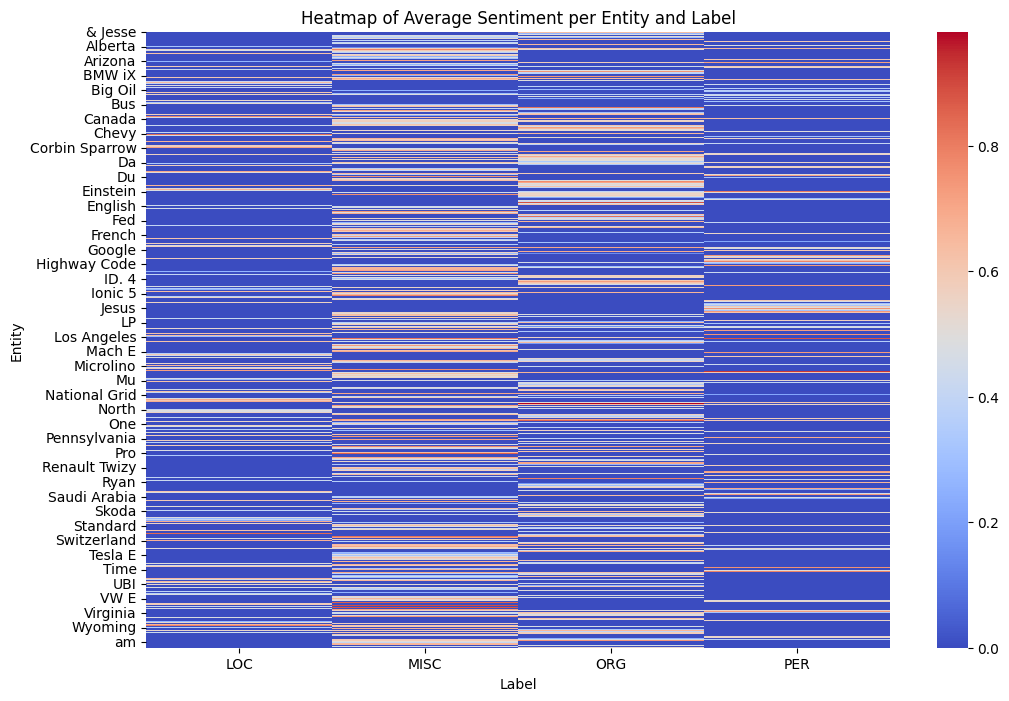

In [38]:
import seaborn as sns

pivot_table = df_entity_summary.pivot_table(
    index="Entity", columns="Label", values="Avg_Sentiment"
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table.fillna(0), cmap="coolwarm", annot=False)
plt.title("Heatmap of Average Sentiment per Entity and Label")
plt.show()

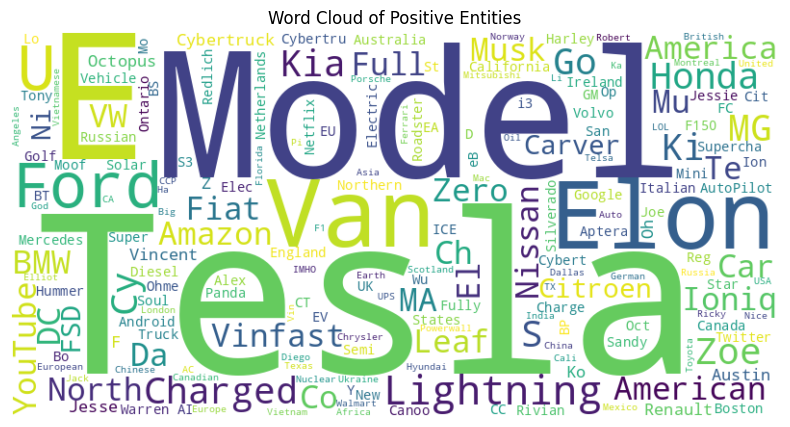

In [49]:
from wordcloud import WordCloud

positive_entities = df_entity_summary[df_entity_summary["Avg_Sentiment"] > 0.2]
text_pos = " ".join(positive_entities["Entity"])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Entities")
plt.show()

<b> PIPELINE B

![My Image](001.png)

In [40]:
# Step 1: Import libraries
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from transformers import pipeline
from textblob import TextBlob
import plotly.express as px

# Step 2: Load JSON data
with open("data.json") as f:
    data = json.load(f)

# Step 3: Load NER model from Hugging Face
ner_pipe = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

# Step 4: Extract entities & sentiment
entity_sentiments = defaultdict(list)

for creator, playlists in data.items():
    for playlist in playlists.values():
        for video in playlist.values():
            for comment_data in video["comments"]:
                text = comment_data["Comment"]
                sentiment = TextBlob(text).sentiment.polarity
                if sentiment <= 0.1:
                    continue  # treat as unlabeled, skip
                prob = sentiment  # proxy for positive confidence
                entities = ner_pipe(text)
                for ent in entities:
                    entity = ent["word"]
                    label = ent["entity_group"]
                    entity_sentiments[(entity, label)].append(prob)

# Step 5: Filter and clean results
def is_valid_entity(entity):
    return not entity.startswith("##") and any(c.isalpha() for c in entity) and len(entity) > 1

entity_summary = {
    key: round(np.mean(scores), 3)
    for key, scores in entity_sentiments.items()
    if len(scores) >= 5 and is_valid_entity(key[0])
}

# Step 6: Convert to DataFrame
df_entity_summary = pd.DataFrame([
    {"Entity": key[0], "Label": key[1], "Avg_Sentiment": val}
    for key, val in entity_summary.items()
])

df_entity_summary.to_csv("entity_sentiment_summary2.csv", index=False)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [23]:
import plotly.express as px

top10 = df_entity_summary.sort_values("Avg_Sentiment", ascending=False).head(10)
fig = px.bar(
    top10,
    x="Entity",
    y="Avg_Sentiment",
    color="Label",
    text="Avg_Sentiment",
    title="Top 10 Entities by Average Sentiment"
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

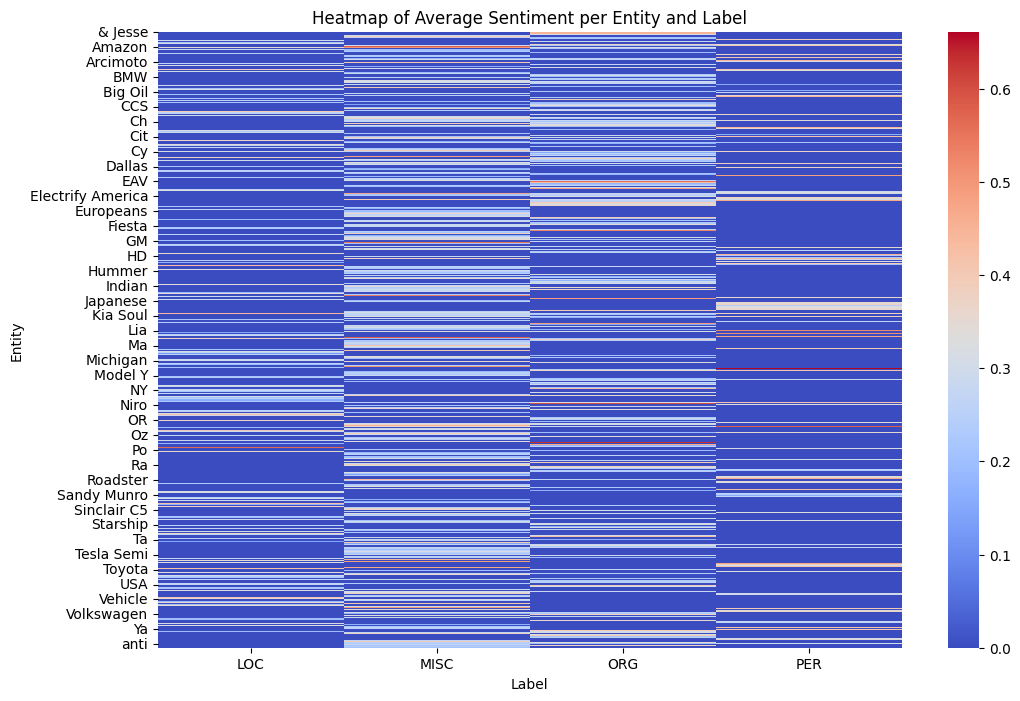

In [ ]:
import seaborn as sns

pivot_table = df_entity_summary.pivot_table(
    index="Entity", columns="Label", values="Avg_Sentiment"
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table.fillna(0), cmap="coolwarm", annot=False)
plt.title("Heatmap of Average Sentiment per Entity and Label")
plt.show()

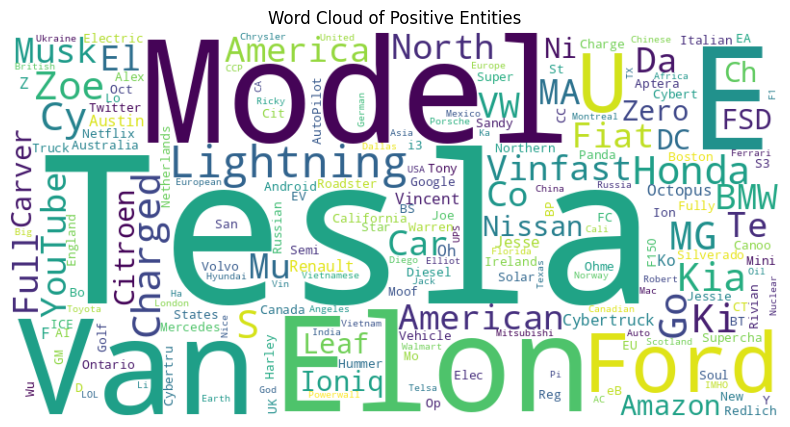

In [ ]:
from wordcloud import WordCloud

positive_entities = df_entity_summary[df_entity_summary["Avg_Sentiment"] > 0.2]
text_pos = " ".join(positive_entities["Entity"])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Entities")
plt.show()

<b> Improved Pipeline C (built upon pipeline A)

What are the differences/ improvements done to Pipeline C — an enhanced version of Pipeline A?

✅ VADER sentiment for better accuracy on informal YouTube comments
✅ Cleaner entity filtering
✅ PU learning using Logistic Regression (semi-supervised)
✅ Summary aggregation per entity
✅ Visualizations using matplotlib and seaborn (instead of Plotly)
✅ CSV export for reporting

In [50]:
# Pipeline C: PU Learning with VADER + Entity Aggregation + Visualization

# === Step 1: Imports ===
import json
import numpy as np
import pandas as pd
from collections import defaultdict
from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 2: Load Data ===
with open("data.json") as f:
    data = json.load(f)

# === Step 3: Load NER Pipeline and VADER ===
ner_pipe = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")
analyzer = SentimentIntensityAnalyzer()

# === Step 4: Extract Entities and VADER Sentiment ===
entities_by_comment = []

for creator, playlists in data.items():
    for playlist in playlists.values():
        for video in playlist.values():
            for comment_data in video["comments"]:
                text = comment_data["Comment"]
                score = analyzer.polarity_scores(text)["compound"]
                label = 1 if score > 0.1 else 0  # PU learning: Positive (1) or Unlabeled (0)
                entities = ner_pipe(text)
                entity_list = [(e["word"], e["entity_group"]) for e in entities]
                if entity_list:  # Only keep if at least one entity
                    entities_by_comment.append((text, entity_list, label))

# === Step 5: Prepare Texts and Labels ===
texts = [text for text, _, _ in entities_by_comment]
labels = [label for _, _, label in entities_by_comment]

# === Step 6: TF-IDF Feature Extraction ===
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)

# === Step 7: PU Learning (Logistic Regression) ===
positive_mask = np.array(labels) == 1
unlabeled_mask = np.array(labels) == 0
clf = LogisticRegression(max_iter=1000)
clf.fit(X[positive_mask | unlabeled_mask], np.array(labels)[positive_mask | unlabeled_mask])

# === Step 8: Predict Positive Probabilities ===
positive_probs = clf.predict_proba(X)[:, 1]

# === Step 9: Aggregate Sentiment per Entity ===
entity_sentiments = defaultdict(list)
for i, (_, entity_list, _) in enumerate(entities_by_comment):
    for entity, label in entity_list:
        entity_sentiments[(entity, label)].append(positive_probs[i])

# === Step 10: Filter & Clean Entities ===
def is_valid_entity(entity):
    return (
        not entity.startswith("##") and
        any(char.isalpha() for char in entity) and
        len(entity) > 1
    )

entity_summary = {
    key: round(np.mean(scores), 3)
    for key, scores in entity_sentiments.items()
    if len(scores) >= 5 and is_valid_entity(key[0])
}

# === Step 11: Convert to DataFrame ===
df_entity_summary = pd.DataFrame([
    {"Entity": key[0], "Label": key[1], "Avg_Sentiment": val}
    for key, val in entity_summary.items()
])

# === Step 12: Sentiment Binning ===
df_entity_summary["Sentiment_Category"] = pd.cut(
    df_entity_summary["Avg_Sentiment"],
    bins=[0, 0.4, 0.6, 0.8, 1],
    labels=["Low", "Neutral", "Positive", "Very Positive"]
)

# === Step 13: Save to CSV ===
df_entity_summary.to_csv("entity_sentiment_summary3.csv", index=False)

# === Step 14: Visualization ===



Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [51]:
import plotly.express as px

top10 = df_entity_summary.sort_values("Avg_Sentiment", ascending=False).head(10)
fig = px.bar(
    top10,
    x="Entity",
    y="Avg_Sentiment",
    color="Label",
    text="Avg_Sentiment",
    title="Top 10 Entities by Average Sentiment"
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()

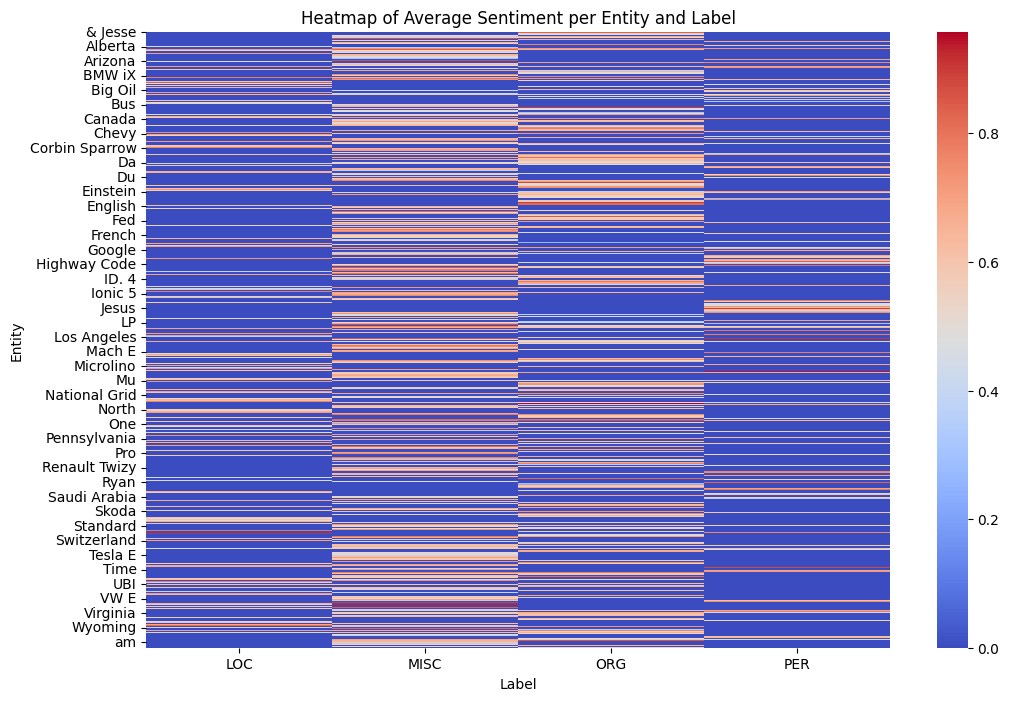

In [52]:
import seaborn as sns

pivot_table = df_entity_summary.pivot_table(
    index="Entity", columns="Label", values="Avg_Sentiment"
)
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table.fillna(0), cmap="coolwarm", annot=False)
plt.title("Heatmap of Average Sentiment per Entity and Label")
plt.show()

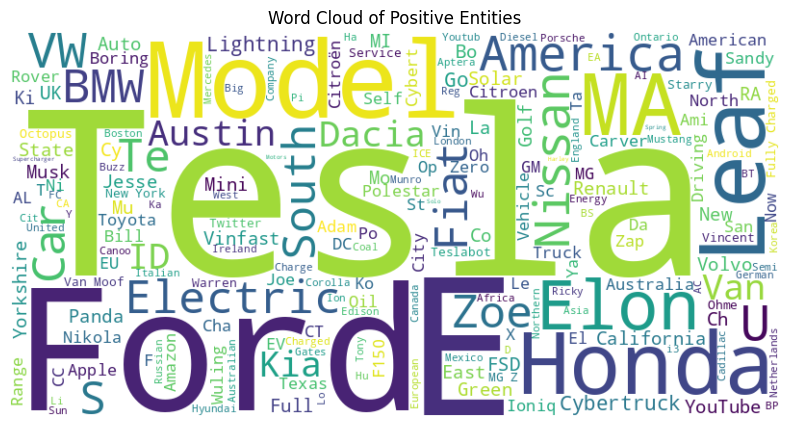

In [53]:
from wordcloud import WordCloud

positive_entities = df_entity_summary[df_entity_summary["Avg_Sentiment"] > 0.2]
text_pos = " ".join(positive_entities["Entity"])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Positive Entities")
plt.show()

<b> Pipeline D

In [2]:
# === Step 1: Imports ===
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

from transformers import pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# === Step 2: Load Data ===
with open("data.json") as f:
    data = json.load(f)

# === Step 3: Load NER (deep learning model) ===
ner_pipe = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english", aggregation_strategy="simple")



Device set to use mps:0


In [3]:
# === Step 4: Sentiment Analyzer ===
analyzer = SentimentIntensityAnalyzer()

# === Step 5: Extract Entities & Sentiment ===
records = []

for creator, playlists in data.items():
    for playlist in playlists.values():
        for video in playlist.values():
            for comment_data in video["comments"]:
                text = comment_data["Comment"]
                entities = ner_pipe(text)
                sentiment = analyzer.polarity_scores(text)["compound"]
                for ent in entities:
                    records.append({
                        "entity": ent["word"],
                        "label": ent["entity_group"],
                        "text": text,
                        "sentiment": sentiment
                    })

df = pd.DataFrame(records)

# Filter for Electric Vehicle relevant entities only (based on domain)
ev_keywords = ["vinfast", "tesla", "charging", "battery", "range", "ev", "model", "car", "vehicle", "autopilot"]
df = df[df["entity"].str.lower().apply(lambda x: any(k in x for k in ev_keywords))]

# === Step 6: PU Learning ===
df = shuffle(df, random_state=42)
df["label_bin"] = df["sentiment"].apply(lambda s: 1 if s > 0.3 else 0 if s < -0.3 else -1)

pos = df[df["label_bin"] == 1]
unlabeled = df[df["label_bin"] == -1]

# Prepare text features
tfidf = TfidfVectorizer(max_features=1000)
X_pos = tfidf.fit_transform(pos["text"])
X_unlabeled = tfidf.transform(unlabeled["text"])

X = np.vstack([X_pos.toarray(), X_unlabeled.toarray()])
y = np.hstack([np.ones(X_pos.shape[0]), np.zeros(X_unlabeled.shape[0])])





Pipeline D - using logreg

In [29]:
# Train PU model with progress bar
print("Training PU Model...")
clf = LogisticRegression(max_iter=500)
for _ in tqdm(range(1), desc="PU Training Progress"):
    clf.fit(X, y)

Training PU Model...


PU Training Progress: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


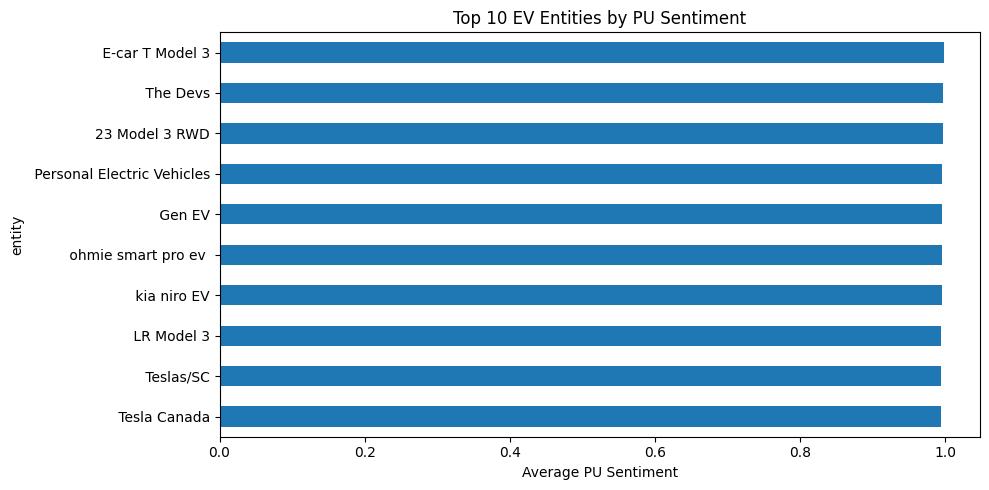

/Users/dennislim/.pyenv/versions/3.12.5/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/dennislim/.pyenv/versions/3.12.5/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


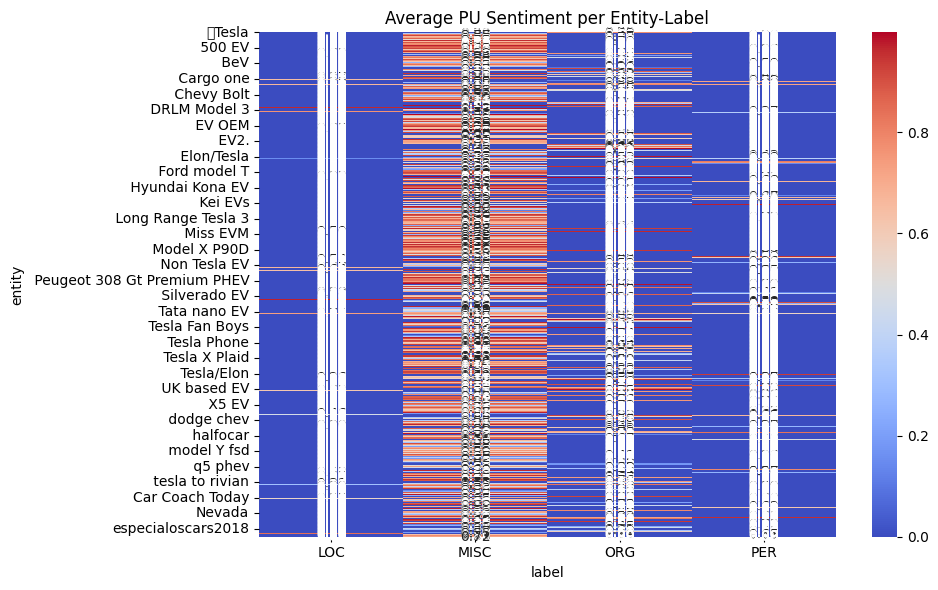

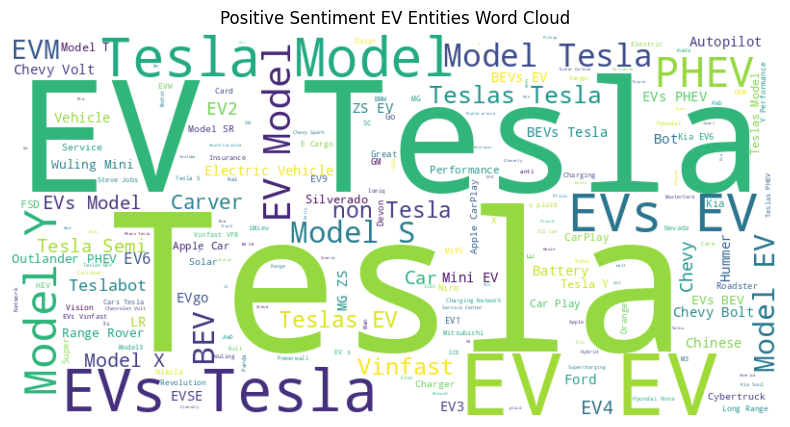

In [30]:
# Predict on full dataset
X_all = tfidf.transform(df["text"]).toarray()
df["pu_prob"] = clf.predict_proba(X_all)[:, 1]

# === Step 7: Visualizations ===

# Top 10 Entities by Avg Sentiment
top_entities = df.groupby("entity")["pu_prob"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_entities.plot(kind="barh")
plt.title("Top 10 EV Entities by PU Sentiment")
plt.xlabel("Average PU Sentiment")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Heatmap: Avg Sentiment by Entity & Label
pivot = df.pivot_table(index="entity", columns="label", values="pu_prob", aggfunc="mean").fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average PU Sentiment per Entity-Label")
plt.tight_layout()
plt.show()

# Word Cloud: Positive Sentiment Entities
text_pos = " ".join(df[df["pu_prob"] > 0.7]["entity"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Sentiment EV Entities Word Cloud")
plt.show()

Pipeline D - using Random Forest

Training PU Model with Random Forest...


PU Training Progress: 100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


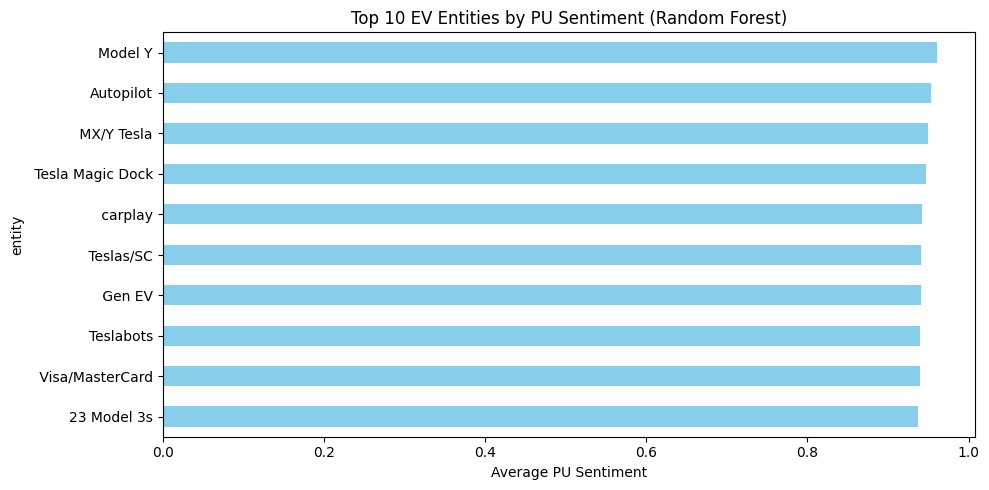

/Users/dennislim/.pyenv/versions/3.12.5/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/dennislim/.pyenv/versions/3.12.5/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


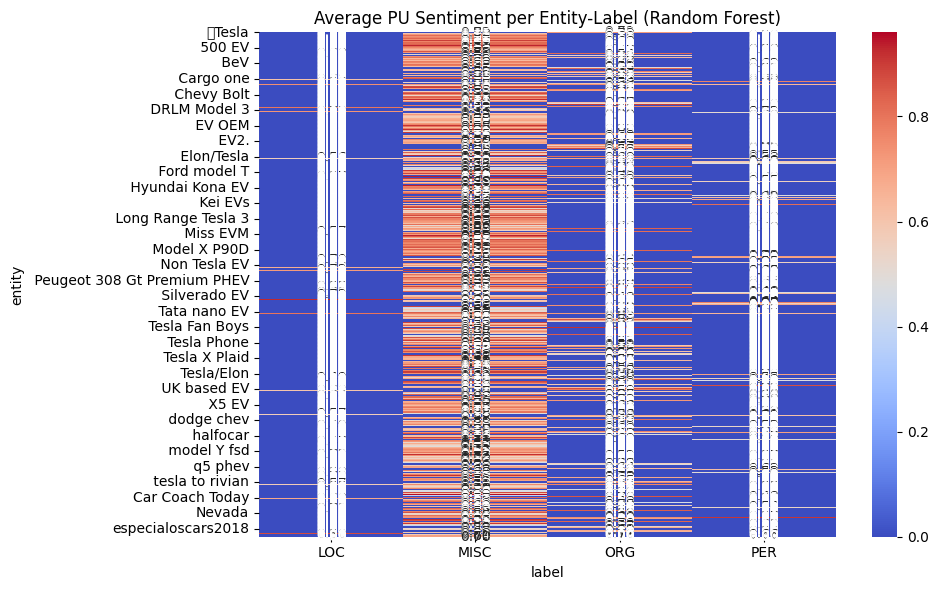

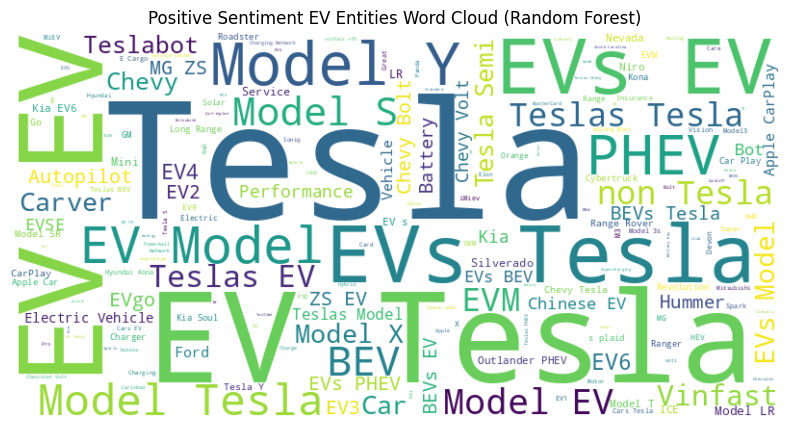

In [31]:
from sklearn.ensemble import RandomForestClassifier

# === Train PU model with progress bar ===
print("Training PU Model with Random Forest...")
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

for _ in tqdm(range(1), desc="PU Training Progress"):
    clf.fit(X, y)

# === Predict on full dataset ===
X_all = tfidf.transform(df["text"]).toarray()
df["pu_prob"] = clf.predict_proba(X_all)[:, 1]

# === Step 7: Visualizations ===

# Top 10 Entities by Avg Sentiment
top_entities = df.groupby("entity")["pu_prob"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_entities.plot(kind="barh", color="skyblue")
plt.title("Top 10 EV Entities by PU Sentiment (Random Forest)")
plt.xlabel("Average PU Sentiment")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Heatmap: Avg Sentiment by Entity & Label
pivot = df.pivot_table(index="entity", columns="label", values="pu_prob", aggfunc="mean").fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average PU Sentiment per Entity-Label (Random Forest)")
plt.tight_layout()
plt.show()

# Word Cloud: Positive Sentiment Entities
text_pos = " ".join(df[df["pu_prob"] > 0.7]["entity"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Sentiment EV Entities Word Cloud (Random Forest)")
plt.show()

Pipeline D - using XGBoost

Training PU Model with XGBoost...


PU Training Progress: 100%|██████████| 1/1 [00:03<00:00,  3.21s/it]


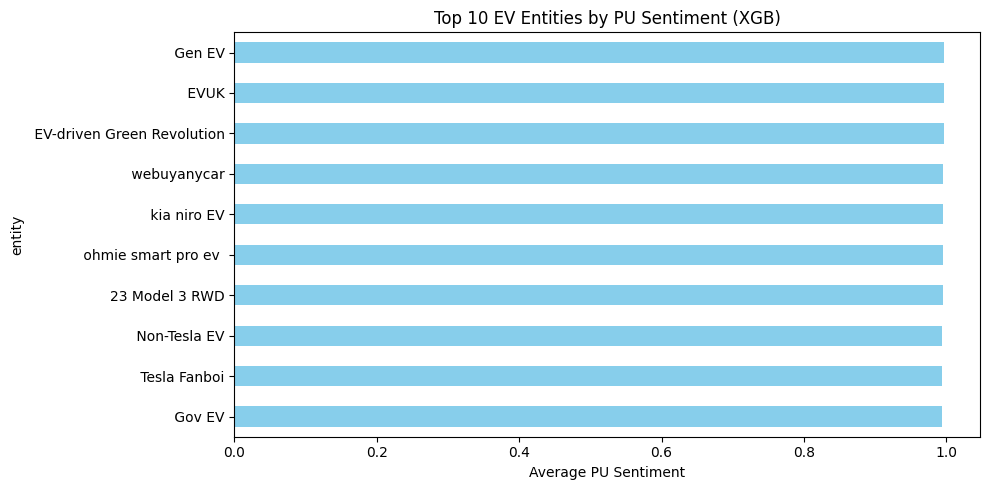

/Users/dennislim/.pyenv/versions/3.12.5/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/dennislim/.pyenv/versions/3.12.5/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


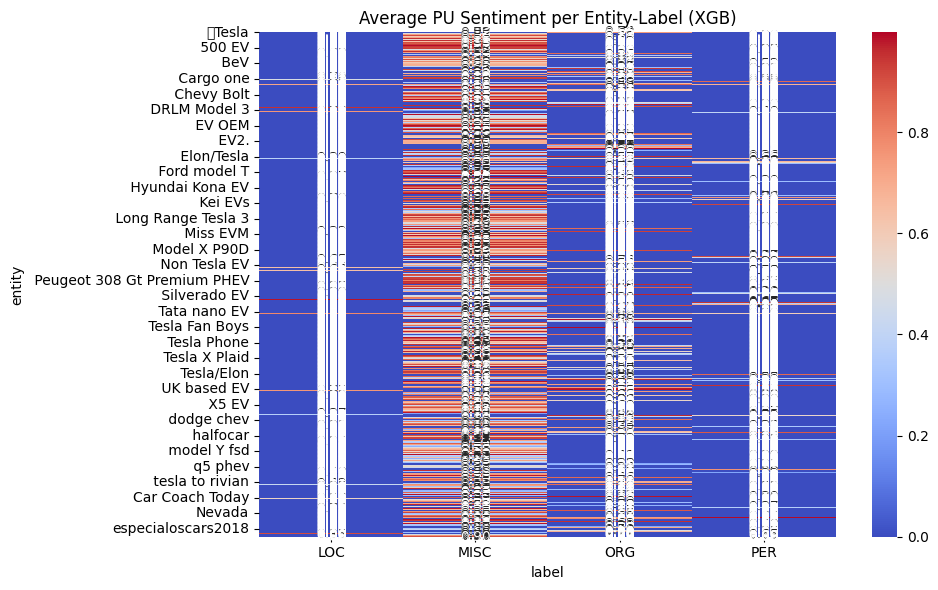

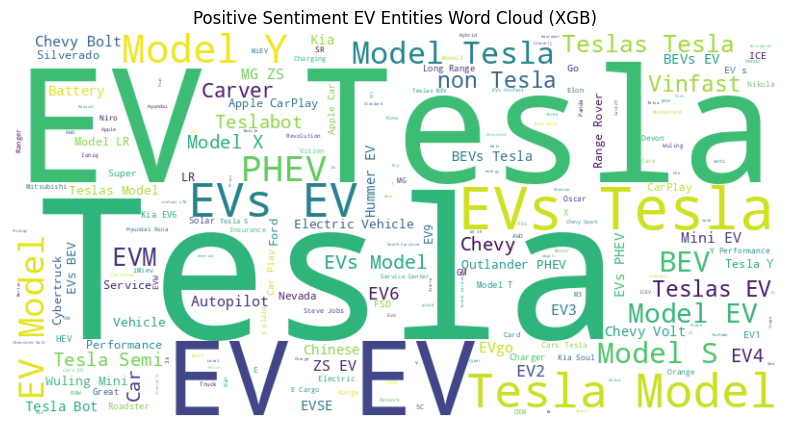

In [4]:
from xgboost import XGBClassifier

# === Train PU model with XGBoost ===
print("Training PU Model with XGBoost...")
clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

from tqdm import tqdm
for _ in tqdm(range(1), desc="PU Training Progress"):
    clf.fit(X, y)

# === Predict on full dataset ===
X_all = tfidf.transform(df["text"]).toarray()
df["pu_prob"] = clf.predict_proba(X_all)[:, 1]

# Top 10 Entities by Avg Sentiment
top_entities = df.groupby("entity")["pu_prob"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 5))
top_entities.plot(kind="barh", color="skyblue")
plt.title("Top 10 EV Entities by PU Sentiment (XGB)")
plt.xlabel("Average PU Sentiment")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Heatmap: Avg Sentiment by Entity & Label
pivot = df.pivot_table(index="entity", columns="label", values="pu_prob", aggfunc="mean").fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average PU Sentiment per Entity-Label (XGB)")
plt.tight_layout()
plt.show()

# Word Cloud: Positive Sentiment Entities
text_pos = " ".join(df[df["pu_prob"] > 0.7]["entity"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Positive Sentiment EV Entities Word Cloud (XGB)")
plt.show()